In [1]:
"""TODO:
    - Refine narrative
    - Make plots
    - Determine presentation form.
        - Kyle very partial to some kind of web app"""

'TODO:\n    - Refine narrative\n    - Make plots\n    - Determine presentation form.\n        - Kyle very partial to some kind of web app'

In [2]:
import pandas as pd
import seaborn as sns 
import numpy


In [3]:
### Lists
## Years common across data
years = ["2020", "2021", "2022", "2023"]
years = sorted(list(years))

months = ["DEC-1", "JAN", "FEB", "MAR", "APR", "MAY", "JUN", "JULY", "AUG", "SEP", "OCT", "NOV"]


In [11]:
### Read in data
## Read in disengagements data
dis_dfs = []
for year in years:
    try:
        annual_disengagements = pd.read_csv(f"data/Disengagements/{year}-Autonomous-Vehicle-Disengagement-Reports-CSV.csv", encoding='utf-8')
    # Allows the search to be broad
    except FileNotFoundError:
        print(f"File for year {year} not found. Skipping...")
        continue
    # Got some kind of unicode error. This fixed it.
    except UnicodeDecodeError:
        # If utf-8 decoding fails, try another common encoding
        annual_disengagements = pd.read_csv(f"data/Disengagements/{year}-Autonomous-Vehicle-Disengagement-Reports-CSV.csv", encoding='latin-1')
    dis_dfs.append(annual_disengagements)

disengagement_df = pd.concat(dis_dfs, ignore_index=True)

# TODO: Cast DATE column as datetype for disengagements

## Read in mileage data
mile_dfs = []
for year in years:
    try:
        annual_mileage = pd.read_csv(f"data/Mileage/{year}-Autonomous-Mileage-Reports-CSV.csv", encoding='utf-8')
    # Allows the search to be broad
    except FileNotFoundError:
        print(f"File for year {year} not found. Skipping...")
        continue
    # Got some kind of unicode error. This fixed it.
    except UnicodeDecodeError:
        # If utf-8 decoding fails, try another common encoding
        annual_mileage = pd.read_csv(f"data/Mileage/{year}-Autonomous-Mileage-Reports-CSV.csv", encoding='latin-1')
    annual_mileage["Year"] = year
    annual_mileage.rename(columns={'ANNUAL TOTAL': 'Mileage Total'}, inplace=True)
    for i, month in enumerate(months, start=4):
        annual_mileage.columns.values[i] = month
    mile_dfs.append(annual_mileage)
    # INFO: each annual report has 22 cols

mileage_df = pd.concat(mile_dfs, ignore_index=True)
# mileage_df.set_index('VIN NUMBER', inplace=True)
mileage_df.head(10)



File for year 2020 not found. Skipping...
File for year 2020 not found. Skipping...


,Manufacturer,Permit Number,VIN NUMBER,Annual Total of Disengagements,DEC-1,JAN,FEB,MAR,APR,MAY,...,SEP,OCT,NOV,Mileage Total,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Year
0,AIMOTIVE INC.,AVT036,JTDKN3DU9A0059509,57.0,0,0,0,77,416,385,...,15,0,0,1827,NaN,NaN,NaN,NaN,NaN,2021
1,AIMOTIVE INC.,AVT036,4T1B21HK6KU514747,49.0,0,0,0,0,0,0,...,82,177,890,1149,NaN,NaN,NaN,NaN,NaN,2021
2,APOLLO AUTONOMOUS DRIVING USA LLC,AVT015,3LN6L5LU2HR615153,1.0,0,0,0,0,0,0,...,75.13,123.66,82.21,830 .04,NaN,NaN,NaN,NaN,NaN,2021
3,APOLLO AUTONOMOUS DRIVING USA LLC,AVT015,3LN6L2LU4GR629715,0.0,0,0,0,0,0,0,...,120.7,121.07,114.26,637.46,NaN,NaN,NaN,NaN,NaN,2021
4,APOLLO AUTONOMOUS DRIVING USA LLC,AVT015,3LN6L5LU1HR627987,0.0,0,0,0,0,0,0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,2021
5,APOLLO AUTONOMOUS DRIVING USA LLC,AVT015,3LN6L2LU5GR607996,0.0,0,0,0,0,0,0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,2021
6,APOLLO AUTONOMOUS DRIVING USA LLC,AVT015,2T2BGMCA5JC021381,0.0,0,0,0,0,0,0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,2021
7,APPLE INC.,AVT030,2T2BGMCA0GC007400,0.0,0,0,0,0,0,0,...,0,16,13,30,NaN,NaN,NaN,NaN,NaN,2021
8,APPLE INC.,AVT030,2T2BGMCA0HC014753,0.0,0,0,1,0,0,0,...,1,0,0,3,NaN,NaN,NaN,NaN,NaN,2021
9,APPLE INC.,AVT030,2T2BGMCA0HC016082,0.0,0,1,0,0,0,0,...,0,0,0,1,NaN,NaN,NaN,NaN,NaN,2021


In [12]:
# What are "Unnamed" colums? Probably useless "reserved"
unnamed_cols = ['Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19', 'Unnamed: 20', 'Unnamed: 21']
for check in unnamed_cols:
    non_null_count = mileage_df[check].notna().sum()
    print(f'Number of non values in {check}: {non_null_count}')

# Empty. Drop 'em
mileage_df = mileage_df.drop(columns=unnamed_cols)
mileage_df.columns


Number of non values in Unnamed: 17: 0
Number of non values in Unnamed: 18: 0
Number of non values in Unnamed: 19: 0
Number of non values in Unnamed: 20: 0
Number of non values in Unnamed: 21: 0


pandas.core.series.Series

In [18]:
print(mileage_df.dtypes)

Manufacturer                       object
Permit Number                      object
VIN NUMBER                         object
Annual Total of Disengagements    float64
DEC-1                              object
JAN                                object
FEB                                object
MAR                                object
APR                                object
MAY                                object
JUN                                object
JULY                               object
AUG                                object
SEP                                object
OCT                                object
NOV                                object
Mileage Total                      object
Year                               object
dtype: object


In [22]:
### Cleaning up types
cast_as_float = [
       'Annual Total of Disengagements', 'DEC-1', 'JAN', 'FEB', 'MAR', 'APR',
       'MAY', 'JUN', 'JULY', 'AUG', 'SEP', 'OCT', 'NOV', 'Mileage Total',
       ]

for col in cast_as_float:
    mileage_df[col] = mileage_df[col].apply(lambda x: x.replace(',', '').replace(' ', '') if isinstance(x, str) else x)
    mileage_df[col] = mileage_df[col].astype(float)

# Assuming df is your DataFrame and 'Column_Name' is the name of the column you want to convert to represent years
mileage_df['Year'] = pd.to_datetime(mileage_df['Year']).dt.year

print(mileage_df.dtypes)


Manufacturer                       object
Permit Number                      object
VIN NUMBER                         object
Annual Total of Disengagements    float64
DEC-1                             float64
JAN                               float64
FEB                               float64
MAR                               float64
APR                               float64
MAY                               float64
JUN                               float64
JULY                              float64
AUG                               float64
SEP                               float64
OCT                               float64
NOV                               float64
Mileage Total                     float64
Year                                int32
dtype: object


In [38]:
### QA the monthly vs sum values
# Calculate the sum of values in the month columns for each row
month_sums = mileage_df.iloc[:, 4:-2].sum(axis=1)  

# Calculate the absolute difference between the sum of month columns and the "Mileage Total" column
absolute_difference = abs(month_sums - mileage_df['Mileage Total'])

# Check if the absolute difference is less than or equal to 2.0
within_tolerance = absolute_difference <= 2.0
fishy = (~within_tolerance).sum()
print("Number of rows where months do not add up to within 1.0 of annual total:", fishy)

# Print rows where the absolute difference is not within 2.0
# print(mileage_df[~within_tolerance])
qa = mileage_df[~within_tolerance]
print(f'Rows where MileageTotal is null: {qa["Mileage Total"].isnull().sum()}')
qa.head()

Number of rows where months do not add up to within 1.0 of annual total: 78
Rows where MileageTotal is null: 77


,Manufacturer,Permit Number,VIN NUMBER,Annual Total of Disengagements,DEC-1,JAN,FEB,MAR,APR,MAY,JUN,JULY,AUG,SEP,OCT,NOV,Mileage Total,Year
1115,"ZOOX, INC",AVT012,5TDDCRFH4GS016607,3.0,159.0,0.0,555.0,500.0,920.0,167.0,248.0,666.0,1122.0,0.0,961.0,1369.0,7749.0,2021
4283,"Zoox, Inc",AVT012,~6566,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,2023
4284,"Zoox, Inc",AVT012,~4600,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,2023
4285,"Zoox, Inc",AVT012,~7108,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,2023
4286,"Zoox, Inc",AVT012,~4894,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,2023


In [ ]:
#### Histogram: miles driven / VIN ######



In [ ]:
### Check if any manufacturers have multiple permit numbers?

In [ ]:
# sunburst of mileage by month? 
# what sotry? weather vehicles can/can't run in

<Axes: xlabel='Year', ylabel='Mileage Total'>

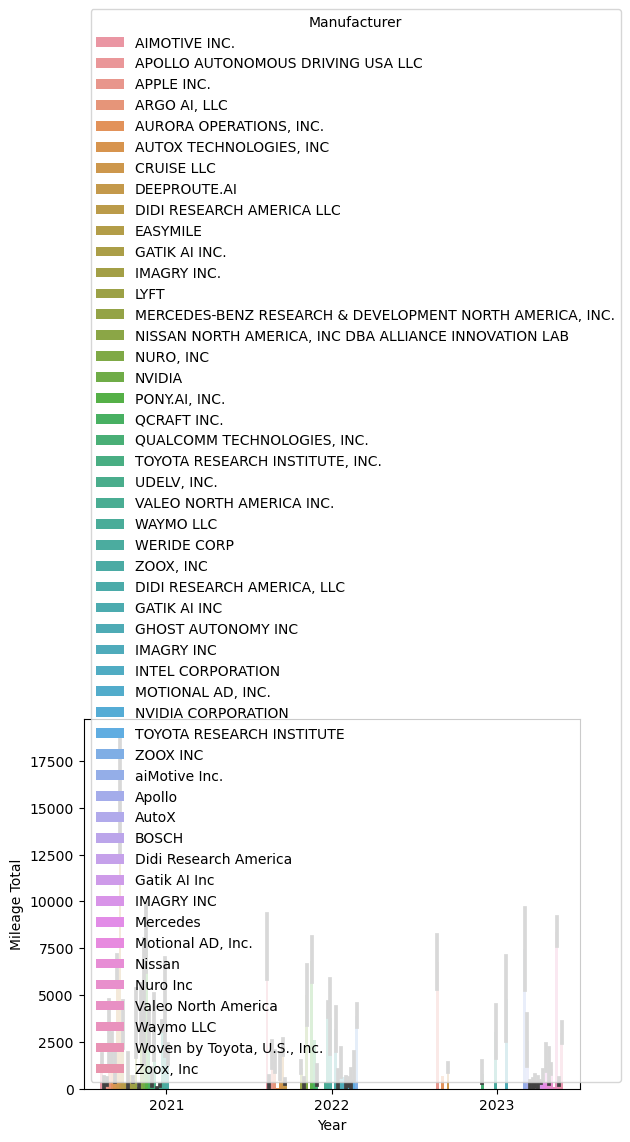

In [40]:
#### Bar: Total Miles driven per year ####
# Optional: groupby company ..."Manufacturer"
sns.barplot(data=mileage_df, x="Year", y="Mileage Total", hue="Manufacturer")

In [ ]:
#### DISENGAGEMENTS PER MILE DRIVEN
# Makes most sense to show by year on a per-company basis. 
# Per vehicle basis doesn't make much sense (since we do not know anything about their operations)


In [ ]:
# INFO: mileage_df.shape = (4360, 46)
print(mileage_df.columns)
mileage_df.head()


In [ ]:
# INFO: disengagement_df.shape = (23579, 10)
print(disengagement_df.columns)